In [1]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [20]:
date = "12_16_2022"
fly = "EPG_GCaMP7f_CsChrimsontdT_fly1"
session = "post_remapping-002"
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'])
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

In [21]:
f = h5py.File(h5name)
data = f['/data'][:]



In [22]:
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)


In [23]:
shifts.shape

(2, 3280, 7)

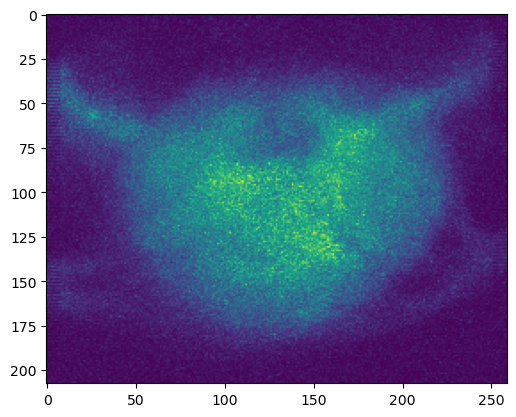

In [24]:
fig, ax = plt.subplots()
ax.imshow(ref_img[0,:,:,:].max(axis=0))

In [25]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(ref_img)

In [26]:
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/napari.pkl'

In [9]:

eb_napari.make_phase_masks()

In [10]:

eb_napari.save_layers(napari_outputs_file)

In [18]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession()
eb_napari.open_existing_session(napari_outputs_file)
# eb_napari.make_phase_masks()


In [11]:
from glob import glob
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

In [12]:
frame_times[-10:]

NameError: name 'frame_times' is not defined

In [13]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [14]:
df_aligned.head()

,Time(ms),start_trigger,opto_trigger,fictrac_cam_exp,fictrac_frame_proc,heading,index,arena_heading,arena_index,heading_cartx,heading_carty,index_cartx,index_carty,arena_heading_cartx,arena_heading_carty,arena_index_cartx,arena_index_carty
0,54.89258,1.0,0.0,25.0,26.0,-0.864339,0.007692,-0.852470,-3.082971,0.649142,-0.760666,0.999970,0.007691,0.658124,-0.752907,-0.998280,-0.058588
1,164.67774,0.0,0.0,52.0,51.0,-0.878192,0.008158,-0.856588,-3.087040,0.638543,-0.769585,0.999967,0.008158,0.655018,-0.755611,-0.998511,-0.054526
2,274.46290,0.0,0.0,52.0,52.0,-0.882003,0.007726,-0.851504,-3.082104,0.635606,-0.772012,0.999970,0.007725,0.658852,-0.752272,-0.998230,-0.059454
3,384.24806,0.0,0.0,51.0,52.0,-0.866118,0.007206,-0.851528,-3.082397,0.647788,-0.761820,0.999974,0.007206,0.658832,-0.752286,-0.998245,-0.059161
4,494.03322,0.0,0.0,52.0,51.0,-0.881415,0.007732,-0.853758,-3.084358,0.636059,-0.771639,0.999970,0.007732,0.657153,-0.753753,-0.998359,-0.057204


In [15]:
F = st2p.preprocessing.signals.extract_2p_timeseries(data, eb_napari.masks, 16)

In [16]:
# baseline
F_base = np.copy(F)
# smooth with a 1s gaussian
# F_base = sp.ndimage.gaussian_filter1d(F_base,100,axis=-1)
F_base = np.percentile(F_base,5,axis=-1, keepdims=True)
# 10 s min max
# F_base = sp.ndimage.minimum_filter1d(F_base, 300, axis=-1)
# F_base = sp.ndimage.maximum_filter1d(F_base, 300, axis=-1)

In [17]:
F = sp.ndimage.gaussian_filter1d(F,3,axis=-1)
# dff = F[1,:,:]/F_base[1,:,:]
dff = 0*F[1,:,:]
dff[:,20:] = sp.stats.zscore(F[1,:,20:],axis=-1)


In [18]:
dff.shape

(16, 3280)

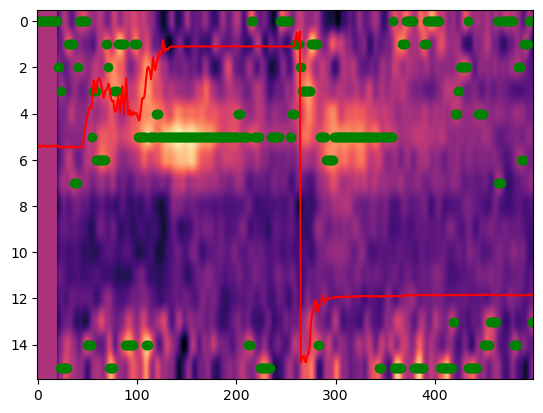

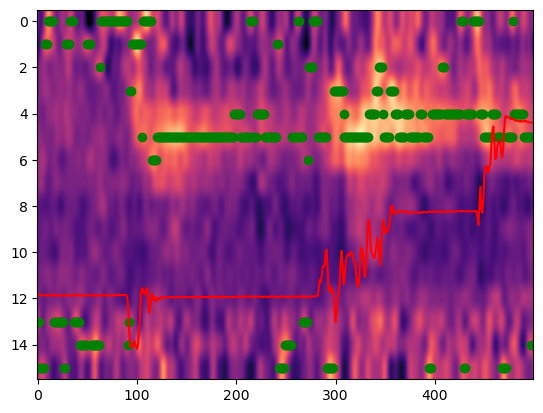

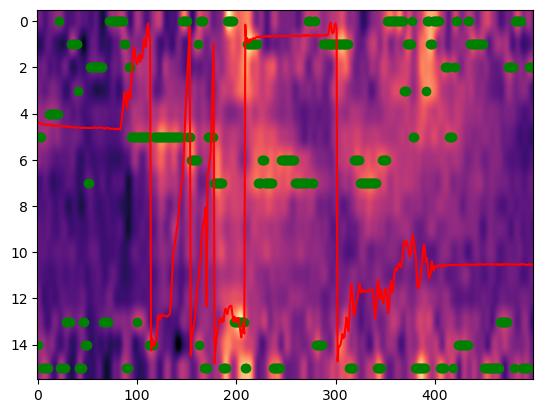

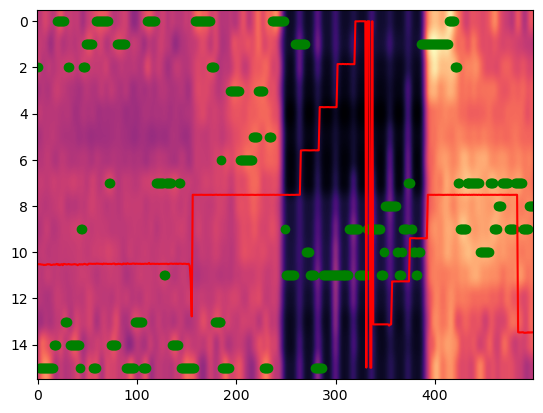

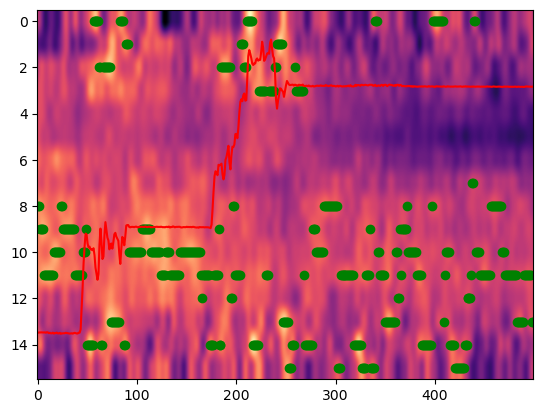

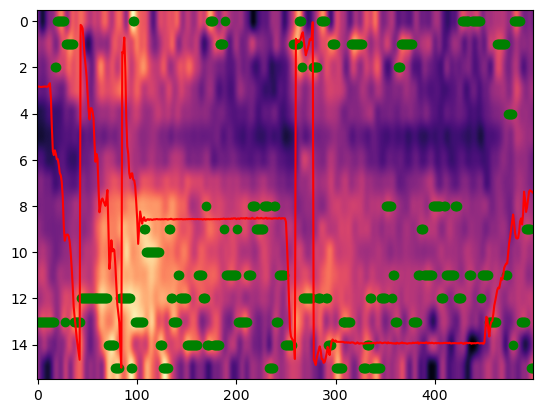

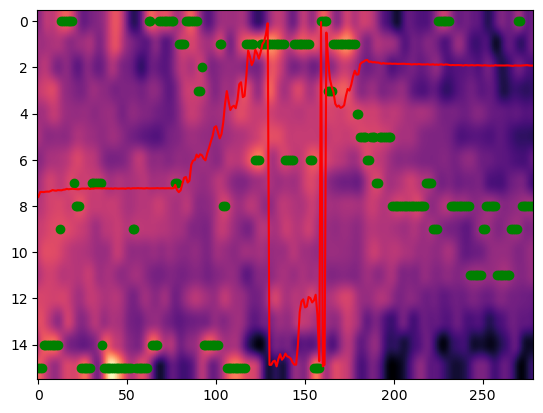

In [19]:
win_size = 500
for start_i in range(0,dff.shape[-1],win_size):
    stop_i = min(start_i+win_size, dff.shape[-1]-1)
    window = slice(start_i, stop_i)
    fig, ax = plt.subplots()
    dff_window = dff[:,window]
    ax.imshow(dff_window,aspect='auto',cmap='magma')
    x = np.arange(stop_i-start_i)
    ax.plot(x,15*(df_aligned['heading'].iloc[window].to_numpy()+np.pi)/2/np.pi,color='red')
    ax.scatter(x,np.argmax(dff_window,axis=0),color='green')


In [36]:
np.diff(df_aligned['Time(ms)']).mean()

109.78516000000003

In [11]:
data.shape

(2, 3280, 7, 208, 259)